### Image Classification Neural Network with memory efficient Grid Search Cross Validation

Here, MNIST Fashion dataset is used to build image classifier along with memory efficient method of Grid Search Cross Validation. As the results and performance of neural network depends on the learning rates, weights initialization (issues caused by local minima), number of layers, activation functions, optimizers, train/test splits etc., it is important to look for the best parameters in addition to cross validation. GridSearchCV is used here and additional steps are added to make sure we don't exhaust the system memory as multiple models with several weights can quickly become memory inefficient.

Importing the necessary libraries

In [14]:
import matplotlib.pyplot as plt
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
from tensorflow.keras import backend as K

#### Importing the Fashion MNIST data

In [15]:
from tensorflow.keras.datasets import fashion_mnist
(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()

#### Normalizing Image arrays

Normalizing the input data ensures the best fit is achieved given best performing training and optimization parameters. This makes the scale of all the features similar so that optimization remains stable not having to come across large values in one feature (eg. Salaries) in comparison to  smaller values in another feature (eg. years of experience). Also the optimal hyperparameters like learning rate are well known for normalized data making hyperparameter tuning a more straightforward process.

As the Convolution layers expect inputs in image format of 3D array and the MNIST input is 2D, the input arrays should be reshaped. (Though the third dimension is for coloured images which would have 3 layers for Red, Blue and Green for each pixel, the reshape here explicitly declares that the 3rd dimension has only one layer).

In [16]:
# Normalize and reshape
train_data = train_data.astype("float32") / 255.0
test_data = test_data.astype("float32") / 255.0
train_data = np.expand_dims(train_data, -1)  # shape (60000, 28, 28, 1)
test_data = np.expand_dims(test_data, -1)


train_data_small = train_data[:10000]
train_labels_small = train_labels[:10000]

#### Visualizing input images

[]

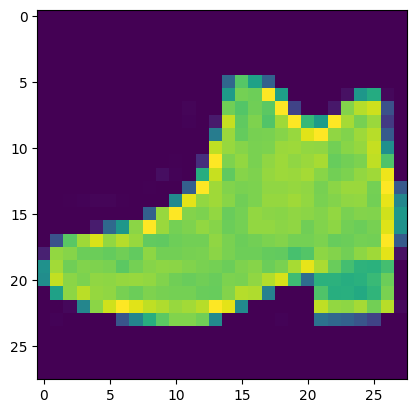

In [18]:
plt.imshow(train_data[15])
plt.plot()

In [19]:
train_data.shape

(60000, 28, 28, 1)

#### Building Model

To provide the model as input to the GridSearchCV, the neural network is created and compiled by calling a custom function. 

In [20]:
def create_model(conv_filters=32,dense_1_units=4,dense_2_units=4,conv=True,optimizer="adam",activation="relu"):

    inputs = tf.keras.Input(shape=(28,28,1))
    if conv:
        x = tf.keras.layers.Conv2D(conv_filters, (3,3), activation=activation)(inputs)
        x = tf.keras.layers.MaxPooling2D((2,2))(x)  # Downsizes the Conv2D output to extract important features and improve computation speed
        x = tf.keras.layers.Flatten()(x)  
        x = tf.keras.layers.Dense(dense_1_units,activation=activation)(x)
        x = tf.keras.layers.Dense(dense_2_units,activation=activation)(x)
    else:
        x = tf.keras.layers.Flatten()(inputs)
        x = tf.keras.layers.Dense(dense_1_units,activation=activation)(x)
        x = tf.keras.layers.Dense(dense_2_units,activation=activation)(x)
        
    outputs = tf.keras.layers.Dense(10,activation="softmax")(x)
    
    model = tf.keras.Model(inputs=inputs,outputs=outputs)

    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer=optimizer,
                 metrics=['accuracy'])

    return model

#### Wrapping the Model for Grid Search
In case of keras model, the model is wrapped into KerasClassifier before feeding into GridSearchCV.

In [21]:
class ClearSessionKerasClassifier(KerasClassifier):
    def fit(self, *args, **kwargs):
        K.clear_session()  # clear before each fit
        return super().fit(*args, **kwargs)

# 4. Instantiate classifier
classifier = ClearSessionKerasClassifier(model=create_model, verbose=0)

#### Setting Parameters Grid
Different dense layer units are used in search and it is also tested if convolution layers improve the performance for image classification at the provided size. In the hidden layers, different activation functions like `relu` and `tanh` are used. As batch sizes affect learning, different batch sizes are also tested. 

In [22]:
param_grid = {
    "model__conv_filters":[32,16],
    "model__dense_1_units":[4,32],
    "model__dense_2_units":[4,32],
    "model__activation":['relu','tanh'],
    "batch_size":[64,128],
    "epochs":[1],
    "model__conv":[True,False]
}

#### Performing Grid Search

In [23]:
grid = GridSearchCV(estimator=classifier,param_grid=param_grid,
                   cv=3,
                   scoring="accuracy",
                   verbose=1)
grid_result = grid.fit(train_data_small,train_labels_small)

print(f"Best Score: {grid_result.best_score_:.4f}")
print(f"Best Params: {grid_result.best_params_}")

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best Score: 0.7948
Best Params: {'batch_size': 64, 'epochs': 1, 'model__activation': 'tanh', 'model__conv': True, 'model__conv_filters': 16, 'model__dense_1_units': 32, 'model__dense_2_units': 32}


#### Grid Search Results
Higher batch size of 64 with tanh activation and convolution layers help achieve better results. The final model is trained using the resulted best parameters on full data while allowing for more epochs.

#### Building the final Model

In [30]:
inputs = tf.keras.layers.Input(shape=(28,28,1),dtype=tf.float32)
x = tf.keras.layers.Conv2D(16,kernel_size=(3,3), activation='tanh')(inputs)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(32,activation='tanh')(x)
x = tf.keras.layers.Dense(32,activation='tanh')(x)
outputs = tf.keras.layers.Dense(10,activation='softmax')(x)

model = tf.keras.Model(inputs=inputs,outputs=outputs)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['accuracy'])

#### Training the final Model

In [31]:
history = model.fit(train_data,train_labels,
                    batch_size=64,epochs=10,
                    validation_data=(test_data,test_labels))

Epoch 1/10
938/938 [==============================] - 7s 7ms/step - loss: 0.4987 - accuracy: 0.8309 - val_loss: 0.3743 - val_accuracy: 0.8689
Epoch 2/10
938/938 [==============================] - 6s 6ms/step - loss: 0.3255 - accuracy: 0.8842 - val_loss: 0.3304 - val_accuracy: 0.8842
Epoch 3/10
938/938 [==============================] - 6s 7ms/step - loss: 0.2801 - accuracy: 0.8991 - val_loss: 0.3019 - val_accuracy: 0.8944
Epoch 4/10
938/938 [==============================] - 6s 6ms/step - loss: 0.2518 - accuracy: 0.9090 - val_loss: 0.3059 - val_accuracy: 0.8905
Epoch 5/10
938/938 [==============================] - 6s 7ms/step - loss: 0.2286 - accuracy: 0.9170 - val_loss: 0.3022 - val_accuracy: 0.8894
Epoch 6/10
938/938 [==============================] - 6s 6ms/step - loss: 0.2094 - accuracy: 0.9246 - val_loss: 0.2815 - val_accuracy: 0.9002
Epoch 7/10
938/938 [==============================] - 6s 6ms/step - loss: 0.1941 - accuracy: 0.9300 - val_loss: 0.2840 - val_accuracy: 0.9010
Epoch 

#### Results
Both training and validation accuracy are above 90%. As validation accuracy started fluctuating aroung 90%, stopping with 10 epochs.

<Axes: >

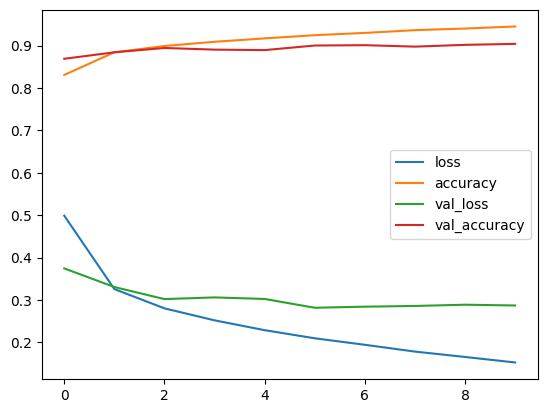

In [32]:
import pandas as pd
pd.DataFrame(history.history).plot()

#### Prediction

In [33]:
y_probs = model.predict(test_data)

313/313 [==============================] - 1s 3ms/step


As y_probs is the output of softmax activation, it shows all the 10 probabilities for 10 classes, we need to choose the class with maximum probability as the prediction.

In [34]:
y_probs[0]

array([1.6420971e-07, 2.2254002e-07, 1.1512032e-07, 1.1179749e-06,
       9.6547161e-08, 2.1041342e-06, 9.1208875e-07, 1.4879454e-04,
       7.6551822e-07, 9.9984574e-01], dtype=float32)

In [35]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Correct. The prediction is T-shirt/top


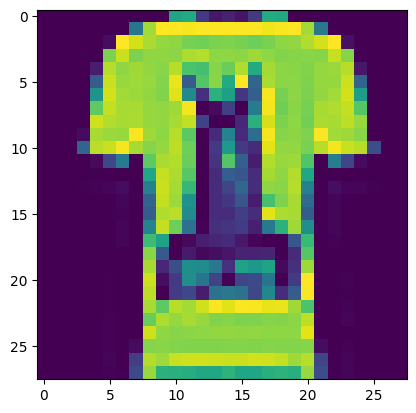

In [45]:
import random
ran = random.randint(0,9999)
plt.imshow(test_data[ran])
if test_labels[ran] == tf.argmax(y_probs[ran]):
    print(f"Correct. The prediction is {class_names[tf.argmax(y_probs[ran])]}")
else:
    print("Failed. Prediction was", class_names[tf.argmax(y_probs[ran])]  )